# 端点から峰追跡することで芯線を求める　両端指定バージョンPP
[1] から順に実行していってください。（実行は シフトを押しながらEnter）

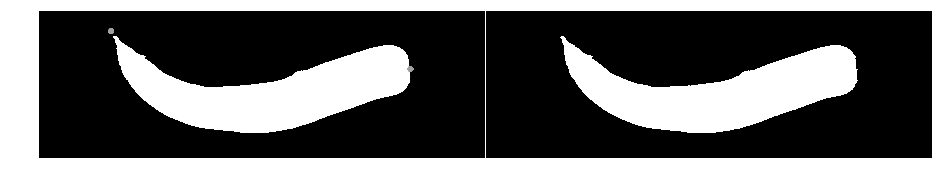

In [1]:
import radishlibPP as rdl
import cv2
%matplotlib inline
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

# 表示のオンオフ
IMGON = True

# 表示のオンオフ
IMGON = True

# 処理対象画像
#srcfile = 'pics/cabumarked.png'
#bwfile = 'pics/cabubw.png'
srcfile = 'pics/horyou2c6kRMarked.jpg'
bwfile = 'pics/horyou2c6kR.jpg'

# 画像の読み込み
marks = cv2.imread(srcfile,0)
bw = cv2.imread(bwfile,0)
# jpeg 等の画像は 完全2値化されていないので、念のために2値化しておく
_,bw=cv2.threshold(bw,128,255,cv2.THRESH_BINARY)

# 表示のオンオフ
IMGON = True
rdl.paraimage(marks,bw,figsize=(16,8))

前提として
- 画像は2階調化されている
- 白領域が１つしかない
- 横向きで、左が先
- 同じ画像に対して2点がマークされた画像を用意する。

例
<img width="512" alt="2017-09-27 14 03 54" src="https://user-images.githubusercontent.com/5820803/30896624-d2cb217c-a38c-11e7-9c15-5d000d02bc12.png">


[PIXLR]https://pixlr.com/editor/ 

- マークは白と黒の中間的な明るさがよい。カラーを使うなら緑色がご抽出されにくい。
- マークの重心に最も近い輪郭点が抽出されるので、マークは図形から離れていても構わない。  
　先端などはむしろ少し離したほうが先端が選ばれる。

最大距離の画像位置(x,y) = ( 2700 , 475 ),  maxR=  203.13


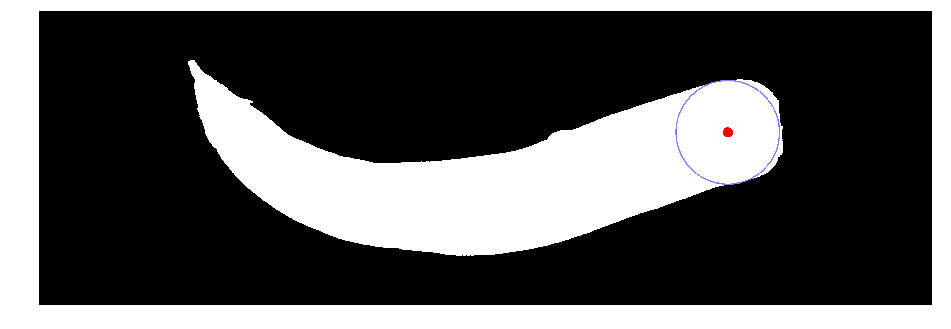

In [2]:
# 距離画像変換　　各白画素について，最も近い黒画素までの距離をデータとする画像を生成
dist = cv2.distanceTransform(bw,cv2.DIST_L2,5)

# 最大の距離は？　　　これが最大半径となる
maxR = np.max(dist)
maxPn = np.argmax(dist)
maxY = int(maxPn/dist.shape[1])
maxX = maxPn - maxY*dist.shape[1]
print("最大距離の画像位置(x,y) = (",maxX, ",",maxY,"),  maxR= ", maxR)

showimg = cv2.cvtColor(bw,cv2.COLOR_GRAY2BGR)
cv2.circle(showimg,(maxX,maxY),maxR,(255,128,128),3)
showimg = cv2.circle(showimg,(maxX,maxY),int(maxR/10),(0,0,255),-1)
rdl.plotimg(showimg)

In [3]:
# 輪郭線データの抽出
ctimg,pts = rdl.getContour(bw,0)

# 確認のための描画
ｃｔx = [i[0][0]  for i in ｐｔｓ[0]]
cty = [i[0][1]  for i in pts[0]]   

# 輪郭データの重複を取り除く
pts =  []
for i in range(len(ctx)):
    if [ctx[i],cty[i]] not in pts:
        pts.append([ctx[i],cty[i]] )
cpts = np.array(pts)

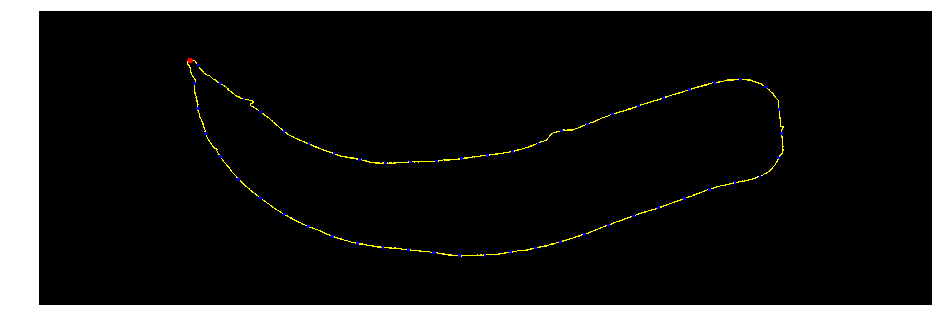

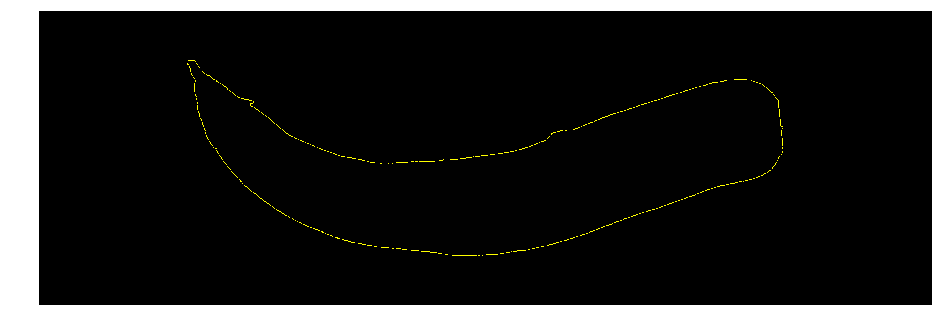

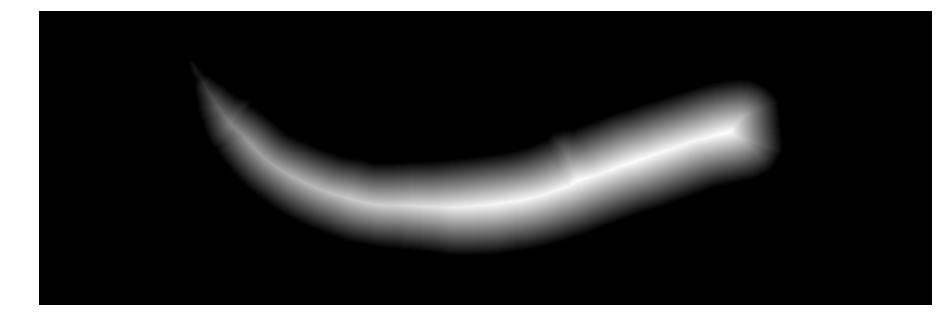

In [4]:
# 確認のために描画
rdl.plotimg(rdl.drawRadishContour(ctimg, cpts, 2,6,10,100,True))
plt.show()

ctrimg = rdl.drawRadishContour(ctimg, cpts)
rdl.plotimg(ctrimg)
plt.show()

# 100は黄色の点の標本間隔、2,6,10　はそれぞれ白、黄色、赤点（開始点）の大きさ

# plt.show()
# 参考として距離画像も描画
rdl.plotimg(dist/np.max(dist),figsize=(16,8))

マーク領域を抽出


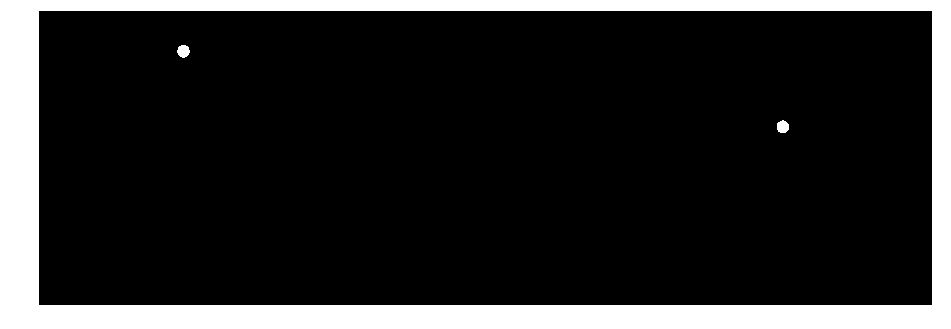

In [5]:
# マーク画像からマークの部分を見つける

_,marks2 =  cv2.threshold(marks, 200,255, cv2.THRESH_TOZERO_INV)
_,marks2 =  cv2.threshold(marks2, 50,255, cv2.THRESH_BINARY)

#　抽出されたマークを確認
print("マーク領域を抽出")
rdl.plotimg(marks2)  
plt.show()

# マーク領域のうち、画像と重なっている部分のみを取り出す
# print("マーク領域と図形の重なり部分のみを抽出")
# marks2 = cv2.bitwise_and(marks2,bw)
# rdl.plotimg(marks2)

重心1= (565 157) 　最寄りの輪郭点= (584, 194)  
重心2= (2916 453) 　最寄りの輪郭点= (2916, 453) 


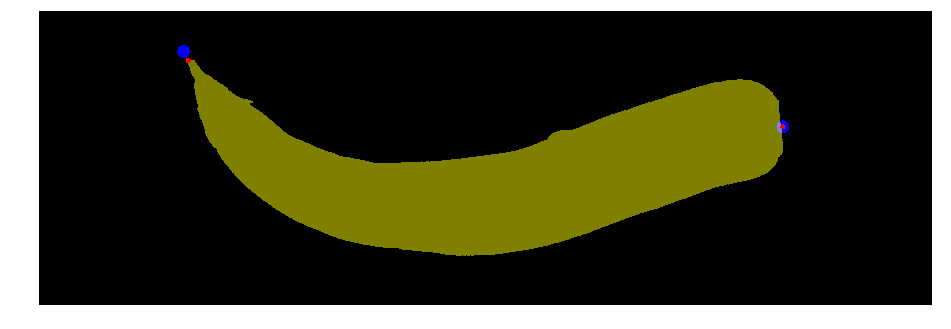

In [6]:
# ２つのマークの重心を求める。 
output = cv2.connectedComponentsWithStats(marks2, connectivity = 8)  
centroids = output[3]  # 連結成分の重心のリスト

g1x = int(centroids[1][0])
g1y = int(centroids[1][1])
g2x = int(centroids[2][0])
g2y = int(centroids[2][1])

# 輪郭線データ cpts の中で最も重心に近い点を選ぶ
dtmp = np.ndarray((cpts.shape),dtype=np.uint32)
dtmp = [(g1x - i[0])**2+(g1y - i[1])**2 for i in cpts]
tmpidx = np.argmin(dtmp)
s1x = cpts[tmpidx][0]
s1y = cpts[tmpidx][1]
dtmp = [(g2x - i[0])**2+(g2y - i[1])**2 for i in cpts]
tmpidx = np.argmin(dtmp)
s2x = cpts[tmpidx][0]
s2y = cpts[tmpidx][1]

print("重心1= ({} {}) 　最寄りの輪郭点= ({}, {})  \n重心2= ({} {}) 　最寄りの輪郭点= ({}, {}) ".format(g1x,g1y,s1x,s1y, g2x,g2y,s2x,s2y ))

shadow = (bw/2).astype(np.uint8)
shadow = cv2.merge((marks2,shadow,shadow))

cv2.circle(shadow,(s1x,s1y),10,(0,0,255),-1)
cv2.circle(shadow,(s2x,s2y),10,(0,0,255),-1)

rdl.plotimg(shadow)

# 指定点から目標点まで距離画像の鞍部を辿るメソッド traceRidgePtoP

** traceRidgePP(dist, x,y, mx,my, para1= 0.7071) **

 **dist** : 距離画像  
 **x,y**  : トレース開始点の座標  
 **mx,my** : 目標点の座標  
 **para1** ：斜め移動の割引率  default = 0.7071 (√2/2)

 **返り値**
 **skel**  :  スケルトンの座標リスト
 

## 補助プログラム
- **getNP(x, y, direct)**
    点(x,y) から direct で指定した方向を中心とした５近傍の座標を返す
- **getNextRidgePP(dist, x,y,direct, mx,my, para1=0.7071) **
　 点(x,y) から direct で指定する方向を中心とした５近傍で最も高い画素値の座標と方向を返す。  
  **direct** : 右を方向０として、時計回りに、１，２,...７  
  **dist** ：距離画像
- **decideDirection(x,y,mx,my)**  
    点(x,y) と点(mx,my）を結ぶ直線に最も近い方向コードを返す


In [7]:
def getNP(x,y,direct):    # 点 (x,y) から direct 方向　を中心とした５点の座標を返すメソッド
    dvecX = [1,1,0,-1,-1,-1,0,1]
    dvecY = [0,1,1,1,0,-1,-1,-1]
    nx = x + dvecX[direct]
    ny = y + dvecY[direct] 
    nRx =  x + dvecX[(direct+1)%8]
    
    nRy =  y + dvecY[(direct+1)%8]
    nLx = x + dvecX[(direct-1)%8]
    nLy = y + dvecY[(direct-1)%8]
    nRx2 =  x + dvecX[(direct+2)%8]
    nRy2 =  y + dvecY[(direct+2)%8]
    nLx2 = x + dvecX[(direct-2)%8]
    nLy2 = y + dvecY[(direct-2)%8]
    return [(nLy2,nLx2),(nLy,nLx),(ny,nx),(nRy,nRx),(nRy2,nRx2)]

# 上下左右斜め8方向のうち、目標に向う方向に近い方向番号を求める
# 方向番号は右を０として、時計回り
#        5  6  7
#        4     0
#        3  2  1
def decideDirection(x,y,mx,my):
    R2 = np.sqrt(2)/2.0
    vec = np.array([[1,0],[R2,R2],[0,1],[-R2,R2],[-1,0],[-R2,-R2],[0,-1],[R2,-R2]])
    dx = mx - x
    dy = my - y
    dotp = np.dot(vec, np.array([dx,dy]))  # 内積のリスト
    return np.argmax(dotp)

def getNextRidgePP(dist, x, y, direct, mx,my, para1=0.7071):
    # dist 距離画像データ
    # (x,y) の次の点を direct 方向とその左2,右2 ５方向のうちから選ぶ。
    # direct は探索方向 
    # (mx,my) 最終到達目標点
    
    ppac5 = getNP(x,y,direct)  # direct 方向を中心とした近傍5点を得る
    [(nLy2,nLx2),(nLy,nLx),(ny,nx),(nRy,nRx),(nRy2,nRx2)]=ppac5 # 5近傍それぞれの座標

    cim = dist[y,x]  # 点(x,y) の距離データ
    dnb2cp5 = np.array([dist[i,j] for i,j in ppac5])-cim # 5近傍の距離データとcimの差分

    # 斜め方向は移動距離が違い、上下左右より若干有利になるので少し割り引いて評価
    if direct % 2 == 0:
            dnb2cp5[1] *= para1
            dnb2cp5[3] *= para1
    else:
            dnb2cp5[0] *= para1
            dnb2cp5[2] *= para1
            dnb2cp5[4] *= para1             
    dmaxes = np.where(dnb2cp5==dnb2cp5.max())  # ５方向の中でもっとも勾配の大きい方向
    if dmaxes[0].size>1:
        idx = int(np.average(dmaxes[0]))
    elif dmaxes[0].size == 1:
        idx = np.argmax(dnb2cp5) # 5方向の中で最も大きな値のインデックス
        if  idx != dmaxes[0]:
            print('not same', idx, dmaxes[0])
    else: # 5方向すべて０かすでに訪れた場所である場合は探索方向を維持
        idx = 2
    
    #print(x,y," {:3.2f}, {:3.2f}, {:3.2f}, {:3.2f}, {:3.2f} - >{}".format(dnb2cp5[0],dnb2cp5[1],dnb2cp5[2],dnb2cp5[3],dnb2cp5[4],idx))

    (ny,nx) = ppac5[idx]
    newdirect = (direct + (idx-2))%8
    return  nx, ny, newdirect


def traceRidgePP(dist,x,y, mx,my, para1= 0.7071):
    USED = -99999
    cim = dist[y,x] # 現在地の距離情報（書き換わる前）
    skel = [[x,y,dist[y,x]]]
    direct = decideDirection(x,y,mx,my)
    
    count = 0
    while  (x - mx)*(x - mx)+(y - my)*(y - my) > 2 and count < 5000:
        count +=1
        nx,ny,nd = getNextRidgePP(dist, x,y,direct, mx,my, para1=para1)
        skel.append([nx,ny,dist[y,x]])
        dist[y,x] = USED
        x,y,direct = nx,ny,nd  
    return skel

In [8]:
# 左右のマークから距離画像の距離最大の点まで距離の鞍部を辿る
dist2 = dist.copy()
skellist1 = traceRidgePP(dist2, s1x,s1y,maxX,maxY,para1=0.7071)
skellist1.append([maxX,maxY,dist2[maxY,maxX]])
skel1 = np.array(skellist1)
skel2 = np.array(traceRidgePP(dist2, s2x,s2y, maxX,maxY,para1=0.7071))
skel1 = skel1[skel1[:,0].argsort()]   # 念のために並べ替え
skel2 = skel2[skel2[:,0].argsort()] 
skeldata = np.concatenate((skel1,skel2) )

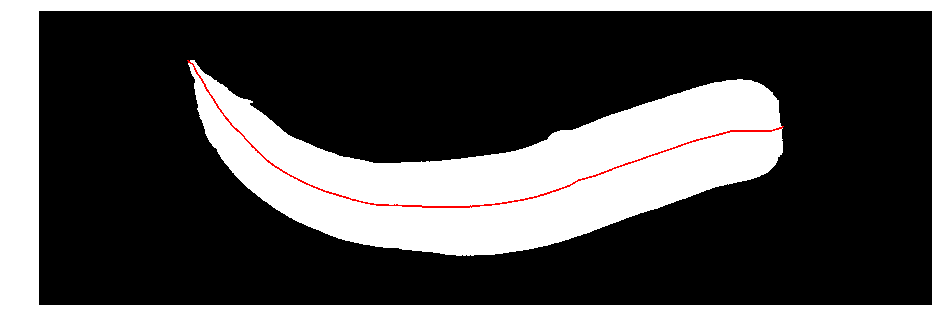

In [9]:
# スケルトンと
def skelOnimg(skeldata,bwimg):
    shape = (bwimg.shape[0],bwimg.shape[1],3)
    img = cv2.merge((bwimg,bwimg,bwimg))
    for i in range (len(skeldata)):
        cv2.circle(img,(int(skeldata[i][0]),int(skeldata[i][1])),3,(0,0,255),-1)
    return img 

recallimg = skelOnimg(skeldata,bw)
rdl.plotimg(recallimg)
plt.show()

In [10]:
skd = skeldata
# 黒画素から最も距離のある，内部の点を基準点として選ぶ
normP = np.argmax(skd[:,2])
xnorm = skd[normP][0]
ynorm = skd[normP][1]
print ("基準点", xnorm,ynorm)
print(np.max(skd[:,0]), np.max(skd[:1]))
print(normP)

基準点 2700.0 475.0
2916.0 584.0
2213


In [11]:
# 基準点からの距離の配列を生成
distance = np.array([np.sign(x-xnorm)*np.sqrt((x-xnorm)**2 + (y - ynorm)**2)  for (x,y) in skd[:,0:2]] ) 
# 縦向きの画像の場合は sign(y-ynom) ，横ならば sign(x-xnorm)

#基準点からの距離でインデックスを並べ替え
index = np.argsort(distance) # 距離順にインデックスを並べ替え
skd = skd[index] # スケルトンデータを距離順に並べ替え
distance = distance[index] # 距離データも並べ替え
skdp = np.array([list(np.append(s,d)) for (s,d) in zip(skd,distance)])
# skpd はスケルトンの(x座標,y座標,輪郭までの距離,基準点からの距離)のリスト

#  並べ替えたので基準点のインデックスを再度調べ直す
normP = np.argmax(skd[:,2])
print (u'基準点',normP,'(',xnorm,ynorm,')')

基準点 2213 ( 2700.0 475.0 )


（解説）径の一番太い位置の中心を基準点 normP として選び、その点からの距離でスケルトン画素を並べ換える。
もしスケルトンが直線状に並んでいるのならば求めた距離は中心軸に沿った距離に等しいが、湾曲している場合、
基準点からの直線距離と軸に沿って測った距離は基準から離れるほどズレが生じてくる。

形状を評価する場合、湾曲を補正した形状を求める必要があるが、それには直線距離ではなく、
軸に沿って測った距離を使うほうが適切である。

理屈の上では軸に沿って距離を積分、つまり積算していけばよいが、デジタル画像の場合近い点の距離は誤差が大きい。
例えば斜め45度に並ぶ点列の距離は1点ずつ距離を積算してしまうと実際の距離のルート２倍になってしまう。

そこで、曲がりが少ないであろう、１０点ごとに距離を測る基準点を設定し、
（基準点間距離＋最寄りの基準点からの距離）で、軸に沿った距離を近似する。

In [12]:
rdl.recalcDistanceP(skdp,normP)

左側修正量 261.6870150172881 (-2134.5765388010805 -> -2396.2635538183686)
右側修正量 2.8232175079432125 (217.1174797200815 -> 219.9406972280247)


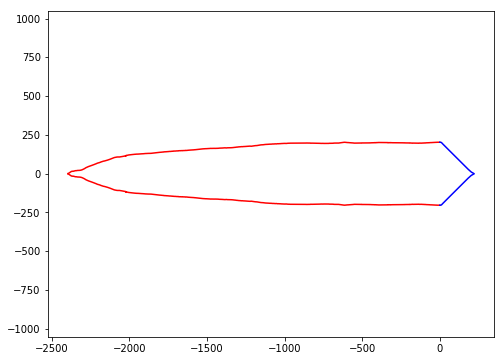

In [13]:
# @interact(invert=False)
def radiusfunc(invert=True):
    if invert:
        for d in skdp: d[3]=-d[3]
    skdN = skdp[skdp[:,3]<= 0] # 基準点より左のデータ
    skdP = skdp[skdp[:,3] > 0] # 基準点より右のデータ
    
    # 横軸を基点からのスケルトン位置までの距離，縦軸をそのスケルトンの距離データとしたグラフ       
    plt.figure(figsize=(8,6))
    plt.axis('equal')    
    # plt.hold(True)
    ydata = np.array(skdN[:,2])
    xdata = np.array(skdN[:,3])
    plt.plot(xdata,ydata,'-',color=(1,0,0.0))
    plt.plot(xdata,-ydata,'-',color=(1,0,0.0))
    ydata = np.array(skdP[:,2])
    xdata = np.array(skdP[:,3])
    plt.plot(xdata,ydata,'-',color=(0,0,1.0))
    plt.plot(xdata,-ydata,'-',color=(0,0,1.0))
    # plt.hold(False)
    plt.show()
    
    
    # invert で再描画する際には、グラフの描画を一旦停止すること。
    # 停止しないと描画されないので注意。
    
radiusfunc(invert=False)


中心軸の画素数=2430


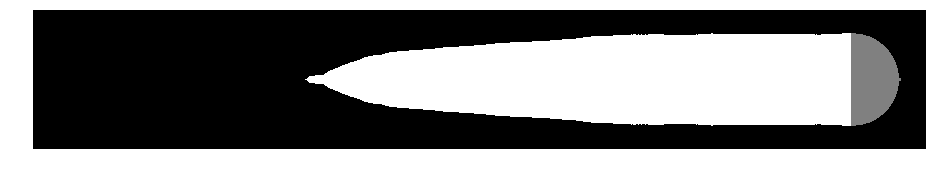

In [14]:
# 中心線を直線化して形状整形した画像の生成
norzimg = rdl.makeNormalizedImage(skdp)
rdl.plotimg(norzimg)

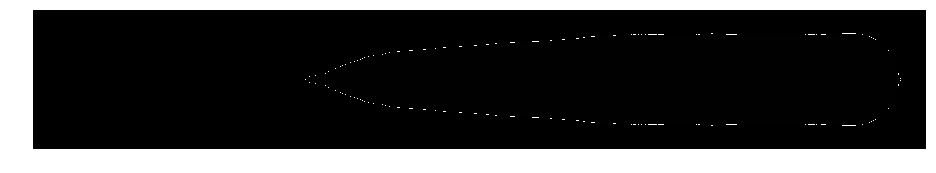

In [15]:
# 輪郭線の抽出
bw,cnt = rdl.getContour(norzimg,0)
cv2.drawContours(bw, cnt, 0, (255,255,255), 1)
rdl.plotimg(bw)

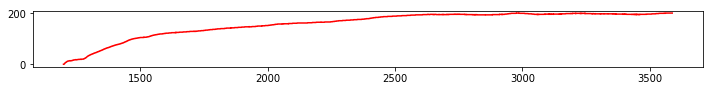

In [16]:
# 先端部分だけの点列の生成
bw,cnt = rdl.getContour(norzimg,2)
xdata = [i[0][0]  for i in cnt[0]]
ydata = [i[0][1]- bw.shape[0]/2 for i in cnt[0]] 
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdata,ydata,"r")

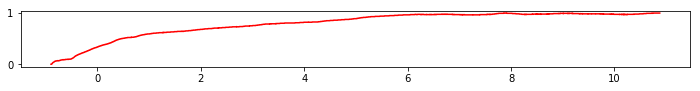

In [17]:
# 最大径を基準に正規化
xdataR = np.array(xdata)/maxR 
ydataR= np.array(ydata)/maxR
xdataR,ydataR = rdl.shiftX(xdataR,ydataR,1/3)    # y = 1/3 付近が x=0 になるようにデータ全体をｘ軸に沿ってシフト
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdataR,ydataR,"r")

# 回帰曲線を求める

# 1

$y = \frac{1}{1+e^{-a(x-b)}}=\frac{1}{1+Be^{-ax}}$ にフィッティング

Instructions for updating:
Use `tf.global_variables_initializer` instead.
    0:(a,b,err) = (    1.0432,    0.0000,     0.0090)
  200:(a,b,err) = (    0.5181,    0.2503,     0.0009)
  400:(a,b,err) = (    0.5200,    0.2618,     0.0009)
  600:(a,b,err) = (    0.5204,    0.2645,     0.0009)
  800:(a,b,err) = (    0.5205,    0.2651,     0.0009)
 1000:(a,b,err) = (    0.5206,    0.2652,     0.0009)
 1200:(a,b,err) = (    0.5206,    0.2652,     0.0009)
 1400:(a,b,err) = (    0.5206,    0.2652,     0.0009)
 1600:(a,b,err) = (    0.5206,    0.2652,     0.0009)
 1800:(a,b,err) = (    0.5206,    0.2652,     0.0009)
 2000:(a,b,err) = (    0.5206,    0.2652,     0.0009)


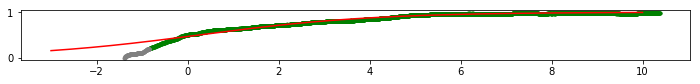

In [24]:
from fit1 import fit1
fit1((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=10,cutoff=0.2)

# 原因はわからないが，１度目は描画に失敗するようである．２回目はうまくいく．

## 2
$$y = \frac{1}{1+e^{-a(x-c)}(1+e^{-b(x-c)})}$$にフィッティング

    0:(a,b,c,err) = (    1.9930,    5.9995,    -0.0056,     0.0246)
  200:(a,b,c,err) = (    0.4015,    5.9396,    -0.5040,     0.0006)
  400:(a,b,c,err) = (    0.4006,    5.9163,    -0.5112,     0.0006)
  600:(a,b,c,err) = (    0.4006,    5.8931,    -0.5108,     0.0006)
  800:(a,b,c,err) = (    0.4007,    5.8700,    -0.5105,     0.0006)
 1000:(a,b,c,err) = (    0.4007,    5.8468,    -0.5102,     0.0006)
 1200:(a,b,c,err) = (    0.4007,    5.8236,    -0.5099,     0.0006)
 1400:(a,b,c,err) = (    0.4008,    5.8004,    -0.5095,     0.0006)
 1600:(a,b,c,err) = (    0.4008,    5.7773,    -0.5092,     0.0006)
 1800:(a,b,c,err) = (    0.4009,    5.7541,    -0.5089,     0.0006)
 2000:(a,b,c,err) = (    0.4009,    5.7309,    -0.5086,     0.0006)


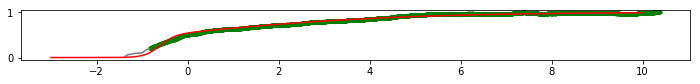

In [23]:
from fit2  import fit2
fit2((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=10,cutoff=0.2)

## 3
$$y = \frac{1}{1+e^{-a(x-c)(1+e^{-b(x-c)})}}$$
にフィッティング

<class 'tensorflow.python.ops.variables.Variable'>
    0:(a,b,c,err) = (    1.9936,    0.0018,     0.0060,     0.0284)
  200:(a,b,c,err) = (    0.4239,    0.5420,     0.1761,     0.0005)
  400:(a,b,c,err) = (    0.4361,    0.6758,     0.1335,     0.0004)
  600:(a,b,c,err) = (    0.4429,    0.7858,     0.1075,     0.0004)
  800:(a,b,c,err) = (    0.4467,    0.8724,     0.0892,     0.0003)
 1000:(a,b,c,err) = (    0.4489,    0.9414,     0.0756,     0.0003)
 1200:(a,b,c,err) = (    0.4503,    0.9974,     0.0652,     0.0003)
 1400:(a,b,c,err) = (    0.4513,    1.0437,     0.0569,     0.0003)
 1600:(a,b,c,err) = (    0.4519,    1.0826,     0.0501,     0.0003)
 1800:(a,b,c,err) = (    0.4523,    1.1156,     0.0445,     0.0003)
 2000:(a,b,c,err) = (    0.4527,    1.1440,     0.0398,     0.0003)


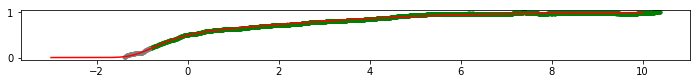

In [22]:
from fit3 import fit3
def shiftX(dx,dy,shift):
         found = False
         offset = 0.0
         for (x,y) in zip(dx,dy):
            if not found and y >shift:
                found = True
                offset = x
         dx = dx - offset
         return dx,dy

# 最大径を基準に正規化
xdataR = np.array(xdata)/maxR 
ydataR= np.array(ydata)/maxR
xdataR,ydataR = shiftX(xdataR,ydataR,1/3)    # y = 1/3 付近が x=0 になるようにデータ全体をｘ軸に沿ってシフト
#plt.figure(figsize=((12,10)))
#plt.gca().set_aspect('equal',adjustable='box')
# plt.plot(xdataR,ydataR,"r")

xdataR,ydataR = shiftX(xdataR,ydataR,0.5)
# fit3 は都合により 半径が0.5 の位置を基準にしてフィッティング
fit３((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=10, cutoff=0.2)